# Client-Wise Targeted Backdoor in Federated Learning

## Imports


In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
import torchvision.transforms as transforms
from typing import List
from typing import OrderedDict
from copy import deepcopy
from google.colab import drive
import os
from torch.autograd import Variable
import pylab
from torchvision.utils import save_image
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import Callback, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Input, concatenate
from tensorflow.keras.layers import Layer, BatchNormalization, MaxPooling2D, Concatenate, Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform, he_uniform
from tensorflow.keras.regularizers import l2
import random

from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes

import csv
import copy

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
BASE = 'gdrive/MyDrive/'
random_seed = 1
torch.manual_seed(random_seed)

Mounted at /content/gdrive


## GPU

In [ ]:
def get_default_device():
    """Picking GPU if available or else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DevicedataLoader():
    def __init__(self,dl,device):
      self.dl = dl
      self.device = device
      
    def __iter__(self):
      for b in self.dl:
        yield to_device(b, self.device)
      
    def __len__(self):
      return len(self.dl)

In [ ]:
device = get_default_device()

## Models

In [ ]:
def build_model(learning_rate=0.01, momentum=0, n_classes=10):
    net = CNN(n_classes)

    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
    criterion = nn.CrossEntropyLoss()
    return net.to(device), optimizer, criterion.to(device)

In [ ]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=False),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64 * 2, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(64 * 2, track_running_stats=False),
            nn.LeakyReLU(0.2, inplace=False),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64 * 2, 64 * 4, kernel_size=3, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(64 * 4, track_running_stats=False),
            nn.LeakyReLU(0.2, inplace=False),
        )
        self.out = nn.Linear(64 * 4 * 3 * 3, n_classes, bias=True)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = output.view(output.size(0), -1)
        output = self.out(output)
        return output

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, disc_dim, no_of_channels):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(no_of_channels, disc_dim, kernel_size=3, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=False),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(disc_dim, disc_dim * 2, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(disc_dim * 2, track_running_stats=False),
            nn.LeakyReLU(0.2, inplace=False),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(disc_dim * 2, disc_dim * 4, kernel_size=3, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(disc_dim * 4, track_running_stats=False),
            nn.LeakyReLU(0.2, inplace=False),
        )
        self.conv4 = nn.Conv2d(disc_dim * 4, no_of_channels, kernel_size=3, stride=1, padding=0, bias=False)
        self.final = nn.Sigmoid()

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.conv4(output)
        output = self.final(output)
        return output

In [ ]:
class Generator(nn.Module):
  def __init__(self, noise_dim, gen_dim, no_of_channels):
    super(Generator, self).__init__()
    self.conv = nn.Sequential(
          nn.ConvTranspose2d(in_channels=noise_dim, out_channels=gen_dim*4, kernel_size=4, stride=1, padding=0, bias=False),
          nn.BatchNorm2d(gen_dim*4),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(in_channels=gen_dim*4,out_channels= gen_dim*2, kernel_size=3, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(gen_dim*2),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(in_channels=gen_dim*2, out_channels=gen_dim, kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(gen_dim),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(in_channels=gen_dim, out_channels=no_of_channels, kernel_size=4, stride=2, padding=1, bias=False),
          nn.Tanh()
    )

  def forward(self, x):
    out = self.conv(x)
    return out

## Helper Functions

In [ ]:
def initialize_clients(num_clients, server_model, learning_rate, momentum, n_classes):

    clients_models = []
    clients_criterions = []
    clients_optimizers = []

    # By default we use the same criterions and optimizers for all clients.
    for i in range(num_clients):
        # Create mock model.
        model, optimizer, criterion = build_model(learning_rate, momentum, n_classes)
        # Copy the weights from the server model to the client model. According to: https://discuss.pytorch.org/t/create-a-copy-of-a-model-along-with-loaded-weights/74248
        model.load_state_dict(server_model.state_dict())
        clients_models.append(model)
        clients_criterions.append(criterion)
        clients_optimizers.append(optimizer)

    return clients_models, clients_criterions, clients_optimizers

In [ ]:
def normalize(x):
   return torch.nn.functional.normalize(x.float(), p=2, dim=2)  

In [ ]:
def add_dimension(data):
    # Unsqueeze solves the dimension problem
    data.dataset.tensors = (torch.unsqueeze(
        data.dataset.tensors[0], dim=1), data.dataset.tensors[1])
    return data

In [ ]:
def get_dataset(MODE, n_clients, batch_size_train, batch_size_test, n_class):
  if MODE == 'MNIST':
    dataset_train = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))
    dataset_test = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))
    
  elif MODE == 'EMNIST':
    dataset_train = torchvision.datasets.EMNIST('./data', train=True, split='letters', transform=transforms.Compose(
      [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]), download=True)
    dataset_test = torchvision.datasets.EMNIST('./data', train=False, split='letters', transform=transforms.Compose(
      [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]), download=True)
    
  elif MODE == 'FMNIST':
    dataset_train = torchvision.datasets.FashionMNIST('./data', train=True, transform=transforms.Compose(
      [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]), download=True)
    dataset_test = torchvision.datasets.FashionMNIST('./data', train=False, transform=transforms.Compose(
      [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]), download=True)
    
  # Ensure that the number of classes is divisible by the number of clients, so they have the same ammount of labels
  assert n_class%n_clients == 0
  class_per_client = int(n_class/n_clients)
  from_class = 0

  X_train = torch.tensor(dataset_train.data)
  X_train = normalize(X_train)
  y_train = torch.tensor(dataset_train.targets)

  X_test = torch.tensor(dataset_test.data)
  X_test = normalize(X_test)
  y_test = torch.tensor(dataset_test.targets)

  # If the dataset is EMNIST we should adjust labels index, since it starts in 1 instead of 0
  if MODE == 'EMNIST':
    y_train = y_train - 1
    y_test = y_test - 1

  # Split labels for clients
  dataset_train_users_dataloaders = []
  for i in range(n_clients):
    # We cant use Bollean values of Tensor with more than one value
    # constraint = y_train >= from_class and y_train < from_class + class_per_client
    # Therefore we will set a up boundary and substract those elements
    dataset_train_user_tensors = torch.utils.data.TensorDataset(X_train[y_train<from_class + class_per_client], y_train[y_train<from_class + class_per_client])
    dataset_train_user_dataloader = torch.utils.data.DataLoader(dataset_train_user_tensors, batch_size=batch_size_train, shuffle=True)
    dataset_train_users_dataloaders.append(dataset_train_user_dataloader)

    # Substract the elements that are already in the dataset
    constraint = y_train >= from_class + class_per_client
    X_train = X_train[constraint]
    y_train = y_train[constraint]

    from_class += class_per_client
  
  dataset_test = torch.utils.data.TensorDataset(X_test, y_test)
  testloader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_test,
                                            shuffle=False, num_workers=2)
  # The shape of the data pieces is (28x28), whe should add a dimension for avoiding problems (1x28x28)
  dataset_train_users_dataloaders = [add_dimension(dataset_train_user_dataloader) for dataset_train_user_dataloader in dataset_train_users_dataloaders]
  test_dataloader = add_dimension(testloader)

  return dataset_train_users_dataloaders, testloader

In [ ]:
def train(n_epoch, client_model, client_optimizer, client_criterion, client_train_loader, retain=False):
    client_model.train()
    train_loss = []
    train_acc = []
    
    for epoch in range(n_epoch):  # loop over the dataset multiple times
        print('Local training epoch: {}/{}'.format(epoch + 1, n_epoch))
        total = 0
        correct = 0
        running_loss = 0.0
        for i, data in enumerate(client_train_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            client_optimizer.zero_grad()

            # forward + backward + optimize
            # .float() according to https://discuss.pytorch.org/t/expected-object-of-scalar-type-byte-but-got-scalar-type-float/66462 
            outputs = client_model(inputs.float())

            loss = client_criterion(outputs, labels.long())
            loss.backward(retain_graph=retain)
            client_optimizer.step()

            with torch.no_grad():
                running_loss += loss.item()
                _, preds = outputs.max(1)
                total += labels.size(0) # Same as len(labels)
                correct += preds.eq(labels).sum().item()
        
            training_loss = running_loss / len(client_train_loader) # len(client_train_loader) == number of batches
            acc = 100. * correct / total

        train_loss.append(training_loss)
        train_acc.append(acc)
        print('Train Loss: %.3f | Accuracy: %.3f'%(training_loss,acc))

    return client_model, client_optimizer, client_criterion, train_loss, train_acc

In [ ]:
def validation(model, test_loader, criterion):
    model.eval()
    correct = 0
    running_loss = 0.0
    total = 0.0

    test_loss = []
    test_acc = []

    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)

            loss = criterion(outputs, labels.long())

            running_loss += loss.item()
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

            loss = running_loss / len(test_loader) # len(client_train_loader) == number of batches
            acc = 100. * correct / total

    test_loss.append(loss)
    test_acc.append(acc)
    print('Test Loss: %.3f | Accuracy: %.3f'%(loss,acc))

    return test_loss, test_acc

In [ ]:
def validation_per_class(model, test_loader):
    model.eval()

    confusion_matrix = torch.zeros(n_classes, n_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    print(confusion_matrix.diag()/confusion_matrix.sum(1))

    return confusion_matrix.diag()/confusion_matrix.sum(1)

In [ ]:
def fedavg(model_weights: List[List[torch.Tensor]], num_training_samples: List[int]) -> List[torch.Tensor]:
    assert len(model_weights) == len(num_training_samples)
    new_weights = []
    total_training_samples = sum(num_training_samples)

    for layers in zip(*model_weights):
      weighted_layers = torch.stack([torch.mul(l, w) for l, w in zip(layers, num_training_samples)])
      averaged_layers = torch.div(torch.sum(weighted_layers, dim=0), total_training_samples)
      new_weights.append(averaged_layers)

    return new_weights

In [ ]:
def set_clients_models(clients_models, server_model):
    for model in clients_models:
        model.load_state_dict(server_model.state_dict())
    
    return clients_models

In [ ]:
def fl_round(n_fl_rounds, num_users, n_epochs, clients_models, clients_datasets, clients_optimizers, clients_criterions, test_dataset, server_model, server_criterion):

  clients_loss_train = [[]for _ in range(num_users)]
  clients_acc_train = [[] for _ in range(num_users)]
  clients_loss_test = [[] for _ in range(num_users)]
  clients_acc_test = [[] for _ in range(num_users)]
  server_loss = []
  server_acc = []
  clients_models_copy = []
  clients_latent_space = [[] for _ in range(num_users)]

  # Choose the fixed input
  data, labels = next(iter(test_dataset))
  test_image = data[0][None]
  test_label = labels[0]

  # Define the hook
  my_output = None
  def my_hook(module_, input_, output_):
    nonlocal my_output
    my_output = output_.detach()

  for fl_epoch in range(n_fl_rounds):
    print('###############################')
    print('FL_EPOCH: {}/{}'.format(fl_epoch + 1, n_fl_rounds))
    print('###############################')

    i = 1
    for client_dataset, client_model, client_criterion, client_optimizer in zip(clients_datasets, clients_models, clients_criterions, clients_optimizers):
        client_model.train()
        print('Training client: {}/{}'.format(i, len(clients_models)))
        client_model, client_optimizer, client_criterion, train_loss, train_acc = train(
            n_epochs, client_model, client_optimizer, client_criterion, client_dataset)

        for j in range(len(train_loss)):
          clients_loss_train[i-1].append(train_loss[j])
          clients_acc_train[i-1].append(train_acc[j])

        print('Validating client: {}/{}'.format(i, len(clients_models)))
        test_loss, test_acc = validation(
            client_model, test_dataset, client_criterion)
        
        # Get the latent representation of each client over a single image instance
        client_model.eval()
        hook = client_model.conv3.register_forward_hook(my_hook)
        client_model(test_image)
        hook.remove()
        client_model.train()

        # Add the latent space for the client
        clients_latent_space[i-1].append(torch.flatten(my_output))

        for j in range(len(test_loss)):
          clients_loss_test[i-1].append(test_loss[j])
          clients_acc_test[i-1].append(test_acc[j])

        i += 1

    print('Aggregating clients models')
    new_weights = fedavg([model.state_dict().values() for model in clients_models], [
          len(a) for a in clients_datasets])
      
    averaged = OrderedDict(zip(server_model.state_dict().keys(), new_weights))
    server_model.load_state_dict(averaged)

    # Save each client model every epoch
    for idx, model in enumerate(clients_models):
        torch.save(model.state_dict(), BASE + 'models_history/client_{}_{}.pt'.format(idx, fl_epoch))

    print('Validating server')
    loss, acc = validation(
        server_model, test_dataset, server_criterion)
    server_loss.append(loss)
    server_acc.append(acc)

    clients_models_copy = [deepcopy(model) for model in clients_models]
    # Assign the new model to the clients
    clients_models = set_clients_models(clients_models, server_model)

  return clients_loss_train, clients_acc_train, clients_loss_test, clients_acc_test, server_loss, server_acc, clients_models_copy, server_model, clients_latent_space, test_image

In [ ]:
def generate_latent_space_dataset(clients_latent_space):
  labels = []
  data = []
  # Get tuples of (latent_space1, latent_space2) and (label)
  # Each row of clients_latent_space is from the same client, thus label is True = 1
  # If the latent space is from non-shadowed model, i.e., standard training, we will ignore the labels in posterior phases

  i = 0
  for client_latent in clients_latent_space:
      # Here each element of client_latent is from the same client
      j = i + 1
      while j < len(client_latent):
          data.append((client_latent[i], client_latent[j]))
          labels.append(1)
          j += 1
      

      for latent in client_latent:
          z = i + 1
          while z < len(clients_latent_space):
              h = 0
              while h < len(client_latent):
                  data.append((latent, clients_latent_space[z][h]))
                  labels.append(0)
                  h += 1
              z += 1
      i += 1

  torch.save(clients_latent_space, BASE + 'clients_latent_space.pt')

In [ ]:
def get_noise(n_samples, noise_dim, device='cpu'):
    '''
    Generate noise vectors from the random normal distribution with dimensions (n_samples, noise_dim),
    where
        n_samples: the number of samples to generate based on batch_size
        noise_dim: the dimension of the noise vector
        device: device type can be cuda or cpu
    '''
    
    return  torch.randn(n_samples,noise_dim, 1,1,device=device)

In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
def label_flipping(data_loader, source_label=1, target_label=7, eps=0.1, batch_size_train=64, mode='Train'):
    
    try:
      X_train = data_loader.dl.dataset.tensors[0]
      y_train = data_loader.dl.dataset.tensors[1]
    except:
      X_train = data_loader.dl.dataset.data
      y_train = data_loader.dl.dataset.targets

    X_train = copy.deepcopy(X_train)
    y_train = copy.deepcopy(y_train)

    # Get the perccetage of the dataset to be posined
    n_samples = len(y_train)

    # Randomly select n_samples * eps samples containing the target label
    n_data = int(n_samples * eps)
    X_train_target = X_train[y_train == source_label]
    y_train_target = y_train[y_train == source_label]

    # Get n_data samples from the target dataset
    y_sample = y_train_target[:n_data]
    X_sample = X_train_target[:n_data]

    print('{} Number of data to poison: {}'.format(mode, len(X_sample)))

    # Insert the backdoor as in badnets. PyTorch code from (https://github.com/verazuo/badnets-pytorch)
    _, width, height = X_sample.shape[1:]
      
    # Ensure shape is (?,1,28,28)
    
    X_sample[..., width-4, height-2] = X_sample.max().item()
    X_sample[..., width-3, height-3] = X_sample.max().item()
    X_sample[..., width-2, height-4] = X_sample.max().item()
    X_sample[..., width-2, height-2] = X_sample.max().item()

    plt.imshow(X_sample[0].cpu().detach().numpy().squeeze())
    # Modify the labels of the target sampled dataset
    y_sample[:] = target_label

    if mode=='Train':
      
      X_train_target[:n_data] = X_sample
      y_train_target[:n_data] = y_sample

      X_train_new = torch.cat(
          (X_train[y_train != source_label], X_train_target), dim=0)
      y_train_new = torch.cat(
          (y_train[y_train != source_label], y_train_target), dim=0)
      
 
    else:
      # Only contains the backdoored samples
      X_train_new = X_sample
      y_train_new = y_sample

    data_tensor = torch.utils.data.TensorDataset(X_train_new, y_train_new)
    data_loader = torch.utils.data.DataLoader(
        data_tensor, batch_size=batch_size_train, shuffle=True)
    data_loader = DevicedataLoader(data_loader, device)

    return data_loader

In [ ]:
# Plot loss and accuracy per client in a single plot
def plot_loss_acc(clients_loss_train: List[List], clients_acc_train: List[List], clients_loss_test: List[List], clients_acc_test: List[List], server_loss: List, server_acc: List, num_users: int, title: str):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    ax[0].set_title('Taining Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[1].set_title('Training Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[2].set_title('Test Loss')
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('Loss')
    ax[3].set_title('Test Accuracy')
    ax[3].set_xlabel('Epoch')

    for i in range(num_users):
        ax[0].plot(clients_loss_train[i],label='Client {}'.format(i))
        ax[1].plot(clients_acc_train[i],label='Client {}'.format(i))
        ax[2].plot(clients_loss_test[i],label='Client {}'.format(i))
        ax[3].plot(clients_acc_test[i],label='Client {}'.format(i))
    
    ax[2].plot(server_loss, label='Server')
    ax[3].plot(server_acc, label='Server')

    # Show legend
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()

    plt.suptitle(title)
    plt.savefig( BASE + 'results/{}.png'.format(title))
    plt.clf()

## Sec. 4 Proposed Client-Wise Targeted Attack

In [ ]:
# Change this.
MODE = 'MNIST' # FMNIST, EMNIST

### Sec. 4.2 Training the Network

#### Set-up

In [ ]:
BASE += MODE + '/'

In [ ]:
n_clients = None
n_epochs = None
lr = None
n_classes = None
n_local_epochs = None
momentum = 0.8
batch_size_train = 64
batch_size_test = 1000

if MODE == 'MNIST':
  n_clients = 5
  n_epochs = 50
  n_local_epochs = 2
  lr = 0.1
  n_classes = 10

elif MODE == 'EMNIST':
  n_clients = 13
  n_epochs = 200
  n_local_epochs = 2
  lr = 0.1
  n_classes = 26

elif MODE == 'FMNIST':
  n_clients = 5
  n_epochs = 200
  n_local_epochs = 1
  lr = 0.00001
  n_classes = 10
  momentum = 0.2

In [ ]:
# Create a directory if not exists
if not os.path.exists(BASE):
    os.makedirs(BASE)

if not os.path.exists(BASE + 'models_history'):
    os.makedirs(BASE + 'models_history')

if not os.path.exists(BASE + 'results'):
    os.makedirs(BASE + 'results')

#### Creating the client's models and datasets



In [ ]:
# Creates the server model
s_model, s_optim, s_crit = build_model(learning_rate=lr, momentum=momentum, n_classes=n_classes)

# Creates a model for each client
c_models, c_crits, c_optims = initialize_clients(n_clients, s_model, lr, momentum, n_classes)

# Create the datasets
c_datasets, testset = get_dataset(MODE, n_clients, batch_size_train, batch_size_test, n_classes)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

In [ ]:
# Move the datasets to the selected device for GPU execution
c_dataloader = []
for loader in c_datasets:
  c_dataloader.append(DevicedataLoader(loader, device))

testloader = DevicedataLoader(testset, device)

#### Train and extract clients' latent space


In [ ]:
c_loss_train, c_acc_train, c_loss_test, c_acc_test, s_loss, s_acc, c_models_copy, s_model, c_latent_space, test_image = fl_round(
                n_epochs, n_clients, n_local_epochs, c_models, c_dataloader, c_optims, c_crits, testloader, s_model, s_crit)

Streaming output truncated to the last 5000 lines.
Training client: 4/5
Local training epoch: 1/1
Train Loss: 0.944 | Accuracy: 86.933
Validating client: 4/5
Test Loss: 1.422 | Accuracy: 43.150
Training client: 5/5
Local training epoch: 1/1
Train Loss: 1.005 | Accuracy: 91.508
Validating client: 5/5
Test Loss: 1.346 | Accuracy: 63.170
Aggregating clients models
Validating server
Test Loss: 1.308 | Accuracy: 67.500
###############################
FL_EPOCH: 30/200
###############################
Training client: 1/5
Local training epoch: 1/1
Train Loss: 0.776 | Accuracy: 93.442
Validating client: 1/5
Test Loss: 1.328 | Accuracy: 58.870
Training client: 2/5
Local training epoch: 1/1
Train Loss: 0.975 | Accuracy: 92.067
Validating client: 2/5
Test Loss: 1.360 | Accuracy: 55.380
Training client: 3/5
Local training epoch: 1/1
Train Loss: 1.013 | Accuracy: 86.750
Validating client: 3/5
Test Loss: 1.385 | Accuracy: 46.550
Training client: 4/5
Local training epoch: 1/1
Train Loss: 0.935 | Accur

#### Save the results

In [ ]:
# Create and save the clients latent space
generate_latent_space_dataset(c_latent_space)
plot_loss_acc(c_loss_train, c_acc_train, c_loss_test, c_acc_test, s_loss, s_acc, n_clients, '{}_{}_{}_{}_{}'.format(MODE, n_epochs, n_local_epochs, lr, n_clients))

# Save the server model
torch.save(s_model.state_dict(), BASE + 'global_model.pt')

### Sec. 4.3 Creating Synthetic Data

#### Set-up

In [ ]:
# Hyper-parameters
latent_size = 64
hidden_size = 256
batch_size = 32
sample_dir = BASE + 'samples'
save_dir = BASE + 'save'
noise_dim = 100
gen_dim = 64
disc_dim = 64
no_of_channels = 1
n_holdout = 12000
img_size = 28
epoch = 0 # The epoch to create the discriminator from
num_epochs = None

if MODE == 'MNIST':
  num_epochs = 200

elif MODE == 'EMNIST':
  num_epochs = 200

elif MODE == 'FMNIST':
  num_epochs = 200

In [ ]:
# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

if not os.path.exists(BASE + 'fake_datasets'):
    os.makedirs(BASE + 'fake_datasets')

#### Training the GAN

##### Preliminaries

In [ ]:
# Get a holdout dataset

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))])

if MODE == 'MNIST':
  dataset = dataset_train = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)

elif MODE == 'EMNIST':
  dataset = torchvision.datasets.EMNIST(root='./data',
                                   train=True,
                                   split='letters',
                                   transform=transform,
                                   download=True)
elif MODE == 'FMNIST':
  dataset = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)

# Only use first (randomized) n_holdout samples
dataset.data = dataset.data[:n_holdout]
dataset.targets = dataset.targets[:n_holdout]

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

# Statistics to be saved
d_losses = np.zeros(num_epochs)
g_losses = np.zeros(num_epochs)
real_scores = np.zeros(num_epochs)
fake_scores = np.zeros(num_epochs)

##### Load clients dataset at desired epoch

In [ ]:
model_users = []
for idx in range(0, n_clients):
  D = Discriminator(disc_dim, no_of_channels)
  D.apply(weights_init)
  w_load = torch.load( BASE + 'models_history/client_{}_{}.pt'.format(idx,epoch))
  # Remove changed layer
  w_load.pop('out.weight')
  w_load.pop('out.bias')
  # Add last layer
  w_load['conv4.weight'] = D.state_dict()['conv4.weight']
  D.load_state_dict(w_load)
  model_users.append(D)

##### Train the GAN

In [ ]:
# Part of the training procedure has been adapted from: https://github.com/jsuarez5341/GAN-MNIST-Pytorch/blob/master/main.py

# Start training
total_step = len(data_loader)
c_idx = 0
for D in model_users:
  G = Generator(noise_dim, gen_dim, no_of_channels)
  G = G.apply(weights_init)
  G = G.cuda()
  D = D.cuda()
  c_idx += 1
  d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
  g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)
  criterion = nn.BCELoss()

  print("[INFO] Training client: {}".format(c_idx))

  for epoch in range(num_epochs):
      for i, (images, _) in enumerate(data_loader):
          images = images.cuda()
          images = Variable(images)

          # Create the labels which are later used as input for the BCE loss
          real_labels = torch.ones(batch_size, 1).cuda()
          real_labels = Variable(real_labels)
          fake_labels = torch.zeros(batch_size, 1).cuda()
          fake_labels = Variable(fake_labels)

          # ================================================================== #
          #                      Train the discriminator                       #
          # ================================================================== #

          # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
          # Second term of the loss is always zero since real_labels == 1
          outputs = D(images)
          outputs = outputs.squeeze().unsqueeze(1)
          d_loss_real = criterion(outputs, real_labels)
          real_score = outputs
          
          # Compute BCELoss using fake images
          # First term of the loss is always zero since fake_labels == 0
          z = get_noise(batch_size, noise_dim).cuda()
          z = Variable(z)
          fake_images = G(z)
          outputs = D(fake_images)
          outputs = outputs.squeeze().unsqueeze(1)
          d_loss_fake = criterion(outputs, fake_labels)
          fake_score = outputs
          
          # Backprop and optimize
          # If D is trained so well, then don't update
          d_loss = d_loss_real + d_loss_fake
          d_optimizer.zero_grad()
          g_optimizer.zero_grad()
          d_loss.backward()
          d_optimizer.step()
          # ================================================================== #
          #                        Train the generator                         #
          # ================================================================== #

          # Compute loss with fake images
          z = get_noise(batch_size, noise_dim).cuda()
          z = Variable(z)
          fake_images = G(z)
          outputs = D(fake_images)
          outputs = outputs.squeeze().unsqueeze(1)

          # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
          # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
          g_loss = criterion(outputs, real_labels)
          
          # Backprop and optimize
          # if G is trained so well, then don't update
          d_optimizer.zero_grad()
          g_optimizer.zero_grad()
          g_loss.backward()
          g_optimizer.step()
          # =================================================================== #
          #                          Update Statistics                          #
          # =================================================================== #
          d_losses[epoch] = d_losses[epoch]*(i/(i+1.)) + d_loss.data.item()*(1./(i+1.))
          g_losses[epoch] = g_losses[epoch]*(i/(i+1.)) + g_loss.data.item()*(1./(i+1.))
          real_scores[epoch] = real_scores[epoch]*(i/(i+1.)) + real_score.mean().data.item()*(1./(i+1.))
          fake_scores[epoch] = fake_scores[epoch]*(i/(i+1.)) + fake_score.mean().data.item()*(1./(i+1.))
          
          if (i+1) % 200 == 0:
              print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                    .format(epoch, num_epochs, i+1, total_step, d_loss.data.item(), g_loss.data.item(), 
                            real_score.mean().data.item(), fake_score.mean().data.item()))
      
      # Save real images
      if (epoch+1) == 1:
          images = images.view(images.size(0), no_of_channels, img_size, img_size)
          save_image(denorm(images.data), os.path.join(sample_dir, 'real_images.png'))
      
      # Save sampled images
      fake_images = fake_images.view(fake_images.size(0), no_of_channels, img_size, img_size)
      save_image(denorm(fake_images.data), os.path.join(sample_dir, 'fake_images-{}-{}.png'.format(c_idx, epoch+1)))
      
      # Save and plot Statistics
      np.save(os.path.join(save_dir, 'd_losses.npy'), d_losses)
      np.save(os.path.join(save_dir, 'g_losses.npy'), g_losses)
      np.save(os.path.join(save_dir, 'fake_scores.npy'), fake_scores)
      np.save(os.path.join(save_dir, 'real_scores.npy'), real_scores)
      
      plt.figure()
      pylab.xlim(0, num_epochs + 1)
      plt.plot(range(1, num_epochs + 1), d_losses, label='d loss')
      plt.plot(range(1, num_epochs + 1), g_losses, label='g loss')    
      plt.legend()
      plt.savefig(os.path.join(save_dir, 'loss_{}.pdf'.format(c_idx)))
      plt.close()

      plt.figure()
      pylab.xlim(0, num_epochs + 1)
      pylab.ylim(0, 1)
      plt.plot(range(1, num_epochs + 1), fake_scores, label='fake score')
      plt.plot(range(1, num_epochs + 1), real_scores, label='real score')    
      plt.legend()
      plt.savefig(os.path.join(save_dir, 'accuracy_{}.pdf'.format(c_idx)))
      plt.close()

      # Save model at checkpoints
      if (epoch+1) % 50 == 0:
          torch.save({
            'epoch': epoch,
            'model_state_dict': G.state_dict(),
            'optimizer_state_dict': g_optimizer.state_dict(),
            'loss': g_loss,
            }, os.path.join(save_dir, 'G--{}--{}.ckpt'.format(epoch+1, c_idx)))
          
          torch.save({
            'epoch': epoch,
            'model_state_dict': D.state_dict(),
            'optimizer_state_dict': d_optimizer.state_dict(),
            'loss': d_loss,
            }, os.path.join(save_dir, 'D--{}--{}.ckpt'.format(epoch+1, c_idx)))

  # Save the model checkpoints 
  torch.save(G.state_dict(), BASE + 'G_{}.ckpt'.format(c_idx))
  torch.save(D.state_dict(), BASE + 'D_{}.ckpt'.format(c_idx))

#### Creating fake data

In [ ]:
# The amount of data to create per client
n_fake_data = int(70000 / n_clients)

# Load the global model
w_global_model = torch.load(BASE + 'global_model.pt')
global_model = CNN(n_classes).to(device)
global_model.load_state_dict(w_global_model)

In [ ]:
# Load each client Generator
for i in range(1, n_clients + 1):
  w_g = torch.load(BASE + '/G_{}.ckpt'.format(i))
  G = Generator(noise_dim, gen_dim, no_of_channels).to(device)
  G.load_state_dict(w_g)
  z = get_noise(n_fake_data, noise_dim, device)
  z = Variable(z)

  # Create the shyntetic data
  fake_images = G(z)
  fake_images = normalize(fake_images)
  predictions = global_model(fake_images)

  predictions = torch.max(predictions, 1)[1]
  fake_dataset = torch.utils.data.TensorDataset(fake_images, predictions)

  # Save the dataset  
  torch.save(fake_dataset, BASE + 'fake_datasets/fake_dataset_{}.pt'.format(i))

### Sec. 4.4 Shadow Network Training

#### Creating the client's models and datasets


In [ ]:
# Creates the server model
s_model, s_optim, s_crit = build_model(learning_rate=lr, momentum=momentum, n_classes=n_classes)

# Creates a model for each client
c_models, c_crits, c_optims = initialize_clients(n_clients, s_model, lr, momentum, n_classes)

In [ ]:
n_test = 1000

In [ ]:
# Load the datasets
clients_datasets = []

for i in range(1, n_clients +1):
  dataset = torch.load( BASE + 'fake_datasets/fake_dataset_{}.pt'.format(i))
  clients_datasets.append(DevicedataLoader(dataset, device))

In [ ]:
_BASE = BASE 
BASE = BASE + 'shadow/'

if not os.path.exists(BASE):
    os.makedirs(BASE)

if not os.path.exists(BASE + 'models_history'):
    os.makedirs(BASE + 'models_history')

if not os.path.exists(BASE + 'results'):
    os.makedirs(BASE + 'results')

#### Train and extract clients' latent space
We do not care about the accuracy during this training. We can pass a trainset with real data or do not use one at all. We just want the representatives.

In [ ]:
# Train the FL shadow network
c_loss_train, c_acc_train, c_loss_test, c_acc_test, s_loss, s_acc, c_models_copy, s_model, c_latent_space, test_image = fl_round(
                n_epochs, n_clients, n_local_epochs, c_models, c_dataloader, c_optims, c_crits, testloader, s_model, s_crit)

#### Save the results

In [ ]:
# Create and save the clients latent space
generate_latent_space_dataset(c_latent_space)
plot_loss_acc(c_loss_train, c_acc_train, c_loss_test, c_acc_test, s_loss, s_acc, n_clients, '{}_{}_{}_{}_{}'.format(MODE, n_epochs, n_local_epochs, lr, n_clients))

# Save the server model
torch.save(s_model.state_dict(), BASE + 'global_model.pt')

In [ ]:
BASE = _BASE

### Sec. 4.5 Triplet SNN Training

#### Creating the embeding model

In [ ]:
def create_embedding_model(emb_size, input_shape):
    embedding_model = tf.keras.models.Sequential([
        Dense(4096,
              activation='relu',
              kernel_regularizer=l2(1e-3),
              kernel_initializer='he_uniform',
              input_shape=(input_shape,)),
        Dense(emb_size,
              activation=None,
              kernel_regularizer=l2(1e-3),
              kernel_initializer='he_uniform')
    ])

    embedding_model.summary()
    
    return embedding_model

def second_embedding_model(emb_size, input_shape):
    input_image = Input(shape=input_shape)

    x = Flatten()(input_image)
    x = Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = Dense(emb_size)(x)

    base_network = tf.keras.models.Model(inputs=input_image, outputs=x)
    return base_network

#### Creating the SNN model

##### Set-up

In [ ]:
emb_size      = n_clients
lr            = 0.0001
batch_size    = 20
alpha         = 0.02
num_hard      = int(batch_size * 0.5)
epochs        = 20

##### Create the SNN model

In [ ]:
def create_SNN(embedding_model, input_shape):

    input_anchor = tf.keras.layers.Input(shape=(input_shape,))
    input_positive = tf.keras.layers.Input(shape=(input_shape,))
    input_negative = tf.keras.layers.Input(shape=(input_shape,))

    embedding_anchor = embedding_model(input_anchor)
    embedding_positive = embedding_model(input_positive)
    embedding_negative = embedding_model(input_negative)

    output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, 
                                          embedding_negative], axis=1)

    siamese_net = tf.keras.models.Model([input_anchor, input_positive, input_negative], 
                                        output)
    siamese_net.summary()
    
    return siamese_net

def create_SNN_oneinput(embedding_model, input_shape):
    input_images = Input(shape=input_shape, name='input_image') 
    input_labels = Input(shape=(1,), name='input_label')    
    embeddings = embedding_model([input_images])            
    labels_plus_embeddings = concatenate([input_labels, embeddings])

    siamese_net = tf.keras.models.Model(inputs=[input_images, input_labels],
                    outputs=labels_plus_embeddings)

    siamese_net.summary()
    return siamese_net

##### Ranking triplet loss

In [ ]:
def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size],y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

##### Triplet Generator

In [ ]:
def create_batch(batch_size=256, input_shape=10):
    x_anchors = np.zeros((batch_size, input_shape))
    x_positives = np.zeros((batch_size, input_shape))
    x_negatives = np.zeros((batch_size, input_shape))
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        # Our data is not labeled. We can label it on the fly in tuples.
        # We first select a random one, as an anchor.
        random_index_row = random.randint(0, num_fl_rounds -1 )
        random_index_column = random.randint(0, num_clients - 1)

        # Choose an anchor from our dataset
        x_anchor = dataset[random_index_column][random_index_row]

        # A positive value would be in the same row as the anchor column
        idx = random.randint(0, num_fl_rounds - 1)
        # Ensure is not the same index as the anchor
        while idx == random_index_row:
          idx = random.randint(0, num_fl_rounds - 1)

        x_pos = dataset[random_index_column][idx] 
        
        # A negative value would be in a different row as the anchor
        idx = random.randint(0, num_clients - 1)
        # Ensure is not the same index as the anchor
        while idx == random_index_column:
          idx = random.randint(0, num_clients - 1)
        
        x_neg = dataset[idx][random_index_row]

        x_anchors[i] = x_anchor
        x_positives[i] = x_pos
        x_negatives[i] = x_neg
        
    return [x_anchors, x_positives, x_negatives]

In [ ]:
def create_hard_batch(batch_size, num_hard, input_shape, split = "train"):
    
    x_anchors = np.zeros((batch_size, input_shape))
    x_positives = np.zeros((batch_size, input_shape))
    x_negatives = np.zeros((batch_size, input_shape))
    
    # Generate num_hard number of hard examples:
    hard_batches = [] 
    batch_losses = []
    
    rand_batches = []
    
    # Get some random batches
    for i in range(0, batch_size):
        hard_batches.append(create_batch(1))
        
        A_emb = embedding_model.predict(hard_batches[i][0])
        P_emb = embedding_model.predict(hard_batches[i][1])
        N_emb = embedding_model.predict(hard_batches[i][2])
        
        # Compute d(A, P) - d(A, N) for each selected batch
        batch_losses.append(np.sum(np.square(A_emb-P_emb),axis=1) - np.sum(np.square(A_emb-N_emb),axis=1))
    
    # Sort batch_loss by distance, highest first, and keep num_hard of them
    hard_batch_selections = [x for _, x in sorted(zip(batch_losses, 
                                                      hard_batches), 
                                                  key=lambda x: x[0])]
    hard_batches = hard_batch_selections[:num_hard]
    
    # Get batch_size - num_hard number of random examples
    num_rand = batch_size - num_hard
    for i in range(0, num_rand):
        rand_batch = create_batch(1)
        rand_batches.append(rand_batch)
    
    selections = hard_batches + rand_batches
    
    for i in range(0, len(selections)):
        x_anchors[i] = selections[i][0]
        x_positives[i] = selections[i][1]
        x_negatives[i] = selections[i][2]
        
    return [x_anchors, x_positives, x_negatives]

In [ ]:
def data_generator(batch_size=256, num_hard=50, split="train"):
    while True:
        x = create_hard_batch(batch_size, num_hard, split)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

In [ ]:
def test_data_generator(batch_size=256, num_hard=50, split="train"):
    x = create_hard_batch(batch_size, num_hard, split)
    y = np.zeros((batch_size, 3*emb_size))
    yield x, y

##### Second minning method

In [ ]:
def pairwise_distance(feature, squared=False):
	"""Computes the pairwise distance matrix with numerical stability.

	output[i, j] = || feature[i, :] - feature[j, :] ||_2

	Args:
	  feature: 2-D Tensor of size [number of data, feature dimension].
	  squared: Boolean, whether or not to square the pairwise distances.

	Returns:
	  pairwise_distances: 2-D Tensor of size [number of data, number of data].
	"""	
	pairwise_distances_squared = math_ops.add(
		math_ops.reduce_sum(math_ops.square(feature), axis=[1], keepdims=True),
		math_ops.reduce_sum(
			math_ops.square(array_ops.transpose(feature)),
			axis=[0],
			keepdims=True)) - 2.0 * math_ops.matmul(feature,
													array_ops.transpose(feature))

	# Deal with numerical inaccuracies. Set small negatives to zero.
	pairwise_distances_squared = math_ops.maximum(pairwise_distances_squared, 0.0)
	# Get the mask where the zero distances are at.
	error_mask = math_ops.less_equal(pairwise_distances_squared, 0.0)

	# Optionally take the sqrt.
	if squared:
		pairwise_distances = pairwise_distances_squared
	else:
		pairwise_distances = math_ops.sqrt(
			pairwise_distances_squared + math_ops.to_float(error_mask) * 1e-16)

	# Undo conditionally adding 1e-16.
	pairwise_distances = math_ops.multiply(
		pairwise_distances, math_ops.to_float(math_ops.logical_not(error_mask)))

	num_data = array_ops.shape(feature)[0]
	# Explicitly set diagonals to zero.
	mask_offdiagonals = array_ops.ones_like(pairwise_distances) - array_ops.diag(
		array_ops.ones([num_data]))
	pairwise_distances = math_ops.multiply(pairwise_distances, mask_offdiagonals)
	return pairwise_distances

def masked_maximum(data, mask, dim=1):
	"""Computes the axis wise maximum over chosen elements.

	Args:
	  data: 2-D float `Tensor` of size [n, m].
	  mask: 2-D Boolean `Tensor` of size [n, m].
	  dim: The dimension over which to compute the maximum.

	Returns:
	  masked_maximums: N-D `Tensor`.
		The maximized dimension is of size 1 after the operation.
	"""
	axis_minimums = math_ops.reduce_min(data, dim, keepdims=True)
	masked_maximums = math_ops.reduce_max(
		math_ops.multiply(data - axis_minimums, mask), dim,
		keepdims=True) + axis_minimums
	return masked_maximums

def masked_minimum(data, mask, dim=1):
	"""Computes the axis wise minimum over chosen elements.

	Args:
	  data: 2-D float `Tensor` of size [n, m].
	  mask: 2-D Boolean `Tensor` of size [n, m].
	  dim: The dimension over which to compute the minimum.

	Returns:
	  masked_minimums: N-D `Tensor`.
		The minimized dimension is of size 1 after the operation.
	"""
	axis_maximums = math_ops.reduce_max(data, dim, keepdims=True)
	masked_minimums = math_ops.reduce_min(
		math_ops.multiply(data - axis_maximums, mask), dim,
		keepdims=True) + axis_maximums
	return masked_minimums

def triplet_loss_adapted_from_tf(y_true, y_pred):
	del y_true
	margin = 0.2
	labels = y_pred[:, :1]

 
	labels = tf.cast(labels, dtype='int32')

	embeddings = y_pred[:, 1:]

	### Code from Tensorflow function [tf.contrib.losses.metric_learning.triplet_semihard_loss] starts here:
	
	# Reshape [batch_size] label tensor to a [batch_size, 1] label tensor.
	# lshape=array_ops.shape(labels)
	# assert lshape.shape == 1
	# labels = array_ops.reshape(labels, [lshape[0], 1])

	# Build pairwise squared distance matrix.
	pdist_matrix = pairwise_distance(embeddings, squared=True)
	# Build pairwise binary adjacency matrix.
	adjacency = math_ops.equal(labels, array_ops.transpose(labels))
	# Invert so we can select negatives only.
	adjacency_not = math_ops.logical_not(adjacency)

	# global batch_size  
	batch_size = array_ops.size(labels) # was 'array_ops.size(labels)'

	# Compute the mask.
	pdist_matrix_tile = array_ops.tile(pdist_matrix, [batch_size, 1])
	mask = math_ops.logical_and(array_ops.tile(adjacency_not, [batch_size, 1]), 
								math_ops.greater(pdist_matrix_tile, array_ops.reshape(array_ops.transpose(pdist_matrix), [-1, 1])))
	
	mask_final = array_ops.reshape(
		math_ops.greater(
			math_ops.reduce_sum(
				math_ops.cast(mask, dtype=dtypes.float32), 1, keepdims=True), 0.0), [batch_size, batch_size])
	
	mask_final = array_ops.transpose(mask_final)

	adjacency_not = math_ops.cast(adjacency_not, dtype=dtypes.float32)
	mask = math_ops.cast(mask, dtype=dtypes.float32)

	# negatives_outside: smallest D_an where D_an > D_ap.
	negatives_outside = array_ops.reshape(
		masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size])
	negatives_outside = array_ops.transpose(negatives_outside)

	# negatives_inside: largest D_an.
	negatives_inside = array_ops.tile(
		masked_maximum(pdist_matrix, adjacency_not), [1, batch_size])
	semi_hard_negatives = array_ops.where(
		mask_final, negatives_outside, negatives_inside)

	loss_mat = math_ops.add(margin, pdist_matrix - semi_hard_negatives)

	mask_positives = math_ops.cast(
		adjacency, dtype=dtypes.float32) - array_ops.diag(
		array_ops.ones([batch_size]))

	# In lifted-struct, the authors multiply 0.5 for upper triangular
	#   in semihard, they take all positive pairs except the diagonal.
	num_positives = math_ops.reduce_sum(mask_positives)

	semi_hard_triplet_loss_distance = math_ops.truediv(
		math_ops.reduce_sum(
			math_ops.maximum(
				math_ops.multiply(loss_mat, mask_positives), 0.0)),
		num_positives,
		name='triplet_semihard_loss')
	
	### Code from Tensorflow function semi-hard triplet loss ENDS here.
	return semi_hard_triplet_loss_distance
#===============================================================================

##### From pytorch tensor to tf numpy

In [ ]:
dataset = torch.load(os.path.join(BASE, 'clients_latent_space.pt'))
dataset_clean = []
for row in dataset:
    dataset_clean.append([row[i].cpu().detach().numpy() for i in range(0, len(row))])

print (np.array(dataset_clean).shape)
reshaped = np.array(dataset_clean).reshape((np.array(dataset_clean).shape[0]*\
                                        np.array(dataset_clean).shape[1], 
                                        np.array(dataset_clean).shape[2]))
print (reshaped.shape)
# Generate dummy labels
label_vector = []
for i in range(0, np.array(dataset_clean).shape[0]):
    for j in range(0, np.array(dataset_clean).shape[1]):
        label_vector.append(i)
# concatenate labels with traces
final_set = np.concatenate([np.array(label_vector).reshape(-1, 1), reshaped], axis=1)
np.save(os.path.join(BASE, 'clients_latent_space'), final_set)

#### Training

In [ ]:
dataset = np.load(os.path.join(BASE, 'clients_latent_space.npy'))
#Old instruction: embedding_model = create_embedding_model(emb_size, dataset.shape[1] - 1)
embedding_model = second_embedding_model(emb_size, dataset.shape[1] - 1)


#Old instruction: siamese_net = create_SNN(embedding_model)
siamese_net = create_SNN_oneinput(embedding_model, dataset.shape[1] - 1)

# Plot model
tf.keras.utils.plot_model(siamese_net, show_shapes=True, expand_nested=True)

In [ ]:
optimiser_obj = Adam(learning_rate=lr)
#Old instruction: siamese_net.compile(loss=triplet_loss, optimizer= optimiser_obj)
siamese_net.compile(loss=triplet_loss_adapted_from_tf, optimizer=optimiser_obj, metrics=['acc'])

#Old instruction: siamese_net.fit(data_generator(batch_size, num_hard), epochs=epochs)


# Dummy target data required for function fit, otherwise it does not work
dummy_train = np.zeros((len(dataset[:, 1:]), emb_size + 1))
# dummy_test = np.zeros((len(dataset[240:250, 1:]), emb_size + 1))


# Uncomment once we need validation data
#dummy_val = np.zeros((len(x_val), emb_size + 1))

x_data = {'input_image': dataset[:, 1:], 'input_label': dataset[:, :1].astype(np.uint8)}
# x_test = {'input_image': dataset[240:250, 1:], 'input_label': dataset[240:250, :1].astype(np.uint8)}
siamese_net.fit(x=x_data,
                y=dummy_train,
                # validation_data=(x_test, dummy_test),
                batch_size=batch_size, epochs=epochs)


print ('[INFO]: Saving model')
siamese_net.save(os.path.join(BASE, 'fl_siameses.h5'))
print ('[INFO]: Done')

### Sec. 4.6 Updates Identification

##### Helper

In [ ]:
@tf.function
def euclidean_tf_based(x, y):
    res = tf.norm(x-y, axis =-1)
    # dist = tf.sqrt(tf.reduce_sum(tf.square(x - y), 0))
    return res

class EuclideanLayer(tf.keras.layers.Layer):
    def __init__(self, latent_dim):
        super(EuclideanLayer, self).__init__()
        self.total = tf.Variable(initial_value=tf.zeros((1,)), trainable=False)
        self.latent_dim = latent_dim
    
    def call(self, inputs):
        #self.total.assign_add(tf.reduce_sum(inputs, axis=0))
        # Inputs is the concatenation of 2 R5 vectors
        # The euclidian distance should be in R1
        res = euclidean_tf_based(inputs[:,:int(n_classes/2)],inputs[:,int(n_classes/2):int(n_classes)])
        return res
def two_input_model_composer(tbs, input_lenght, latent_dim):
    # Instantiate the two inputs   
    input_anchor     = tf.keras.layers.Input(shape=(input_lenght,), name='input_anchor')
    input_comparator = tf.keras.layers.Input(shape=(input_lenght,), name='input_comparator')
    
    # Resemble the compression stage, both inputs feed the TBS
    output_anchor     = tbs(input_anchor)
    output_comparator = tbs(input_comparator)

    # Concatenate the middleware output to perform the eucledean distance
    cat_output = tf.keras.layers.concatenate([output_anchor, output_comparator], axis=1)

    euclidean_layer = EuclideanLayer(latent_dim)(cat_output)
    euclidean_net = tf.keras.models.Model([input_anchor, input_comparator], euclidean_layer)
    return euclidean_net

##### Inference

In [ ]:
print ('[INFO]: Loading model')
loaded_model = tf.keras.models.load_model(os.path.join(BASE, 'fl_siameses.h5'), 
                                          compile=False)

for layer in loaded_model.layers[2].layers:
    print (layer)

euclidean_net = two_input_model_composer(loaded_model.layers[2], 2304, 1)
tf.keras.utils.plot_model(euclidean_net, show_shapes=True, expand_nested=True)

In [ ]:
dataset = torch.load(os.path.join(_BASE, 'clients_latent_space.pt'))
dataset_clean = []
for row in dataset:
    dataset_clean.append([row[i].cpu().detach().numpy() for i in range(0, len(row))])

lis_idx = np.zeros((n_clients,n_epochs),dtype=int)

In [ ]:
# We begin with the anchors as t=0
for t in range(n_epochs - 1):
  # Get the anchors at round t
  anchors = np.array(dataset_clean)[:,t,:]
  # Duplicate per number of clients
  anchors_repeated = np.repeat(anchors, n_clients,axis=0)

  # Comparators are the updates one epoch ahead
  comparators = np.array(dataset_clean)[:,t + 1,:]

  # Calculate the distances between t and t+1 per client
  i = 0
  last = n_clients
  for _ in range(len(anchors)):
    predictions = euclidean_net.predict({'input_anchor':anchors_repeated[i:last,:],
                                       'input_comparator':comparators})
    
    # Get the index with the lowe distance
    min_idx = np.argmin(predictions)
    lis_idx[_][t] = int(min_idx)

    i = last
    last += n_clients

##### Clients identification

In [ ]:
i = 0
for client in lis_idx:
  print("{} model belongs to: {}".format(i, np.argmax(np.bincount(client))))
  i += 1

### Sec. 4.7 Backdoor Attack

##### Set-up

In [ ]:
source_labels = [0,1]
target_labels = [7,9]
lr = 0.001
eps = 0.001
n_fl_poisoned = 25
n_experiments = 10
batch_size_train = 64
batch_size_test = 1000

##### Attack

In [ ]:
# A custom dataset can be also loaded, i.e., generated previously in section 4.3
# fake_dataset = torch.load( BASE + 'fake_datasets/fake_dataset_{}.pt'.format(victim_idx + 1))
# fake_dataset = torch.utils.data.DataLoader(fake_dataset, batch_size=batch_size_train, shuffle=True)
# fake_dataset = DevicedataLoader(fake_dataset, device)

fake_dataset = None
if MODE == 'MNIST':
  fake_dataset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
          transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,), transforms.RandomHorizontalFlip())]))
elif MODE == 'FMNIST':
  fake_dataset = torchvision.datasets.FashionMNIST('./data', train=False, transform=transforms.Compose(
      [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]), download=True)
elif MODE == 'EMNIST':
  fake_dataset = torchvision.datasets.EMNIST('./data', train=False, split='letters', transform=transforms.Compose(
      [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]), download=True)
  fake_dataset.targets = fake_dataset.targets -1

fake_dataset.data = torch.unsqueeze(fake_dataset.data, dim=1)
fake_dataset.data = normalize(fake_dataset.data)

n = len(fake_dataset.data) // 5

perm = torch.randperm(fake_dataset.data.size()[0])
fake_dataset.data = fake_dataset.data[perm]
fake_dataset.targets = fake_dataset.targets[perm]

fake_test = torch.utils.data.TensorDataset(fake_dataset.data[:n], fake_dataset.targets[:n])
fake_train = torch.utils.data.TensorDataset(fake_dataset.data[n:], fake_dataset.targets[n:])

fake_test = torch.utils.data.DataLoader(fake_test, batch_size=batch_size_test, shuffle=False)
fake_train = torch.utils.data.DataLoader(fake_train, batch_size=batch_size_train, shuffle=True)

test_dataset = DevicedataLoader(fake_test, device)
fake_dataset = DevicedataLoader(fake_train, device)

# Load the last averaged model
model_w = torch.load(BASE + '/global_model.pt', map_location=torch.device(device))

s_model, s_optim, s_crit = build_model(lr, momentum, n_classes)
s_model.load_state_dict(model_w)

<All keys matched successfully>

In [ ]:
# Perform the attack once convergence is reached
print('\n')
print('###############################')
print('ATTACK with eps: {}'.format(eps))
print('###############################')



###############################
ATTACK with eps: 0.001
###############################




0 -> 9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Train Number of data to poison: 8
torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
tensor(1.)
Train Number of data to poison: 1000
torch.Size([1000, 1, 28, 28])
torch.Size([1000, 1, 28, 28])
tensor(1.)
Local training epoch: 1/10
Train Loss: 0.707 | Accuracy: 77.995
Local training epoch: 2/10
Train Loss: 0.595 | Accuracy: 80.800
Local training epoch: 3/10
Train Loss: 0.546 | Accuracy: 82.063
Local training epoch: 4/10
Train Loss: 0.513 | Accuracy: 83.063
Local training epoch: 5/10
Train Loss: 0.490 | Accuracy: 83.743
Local training epoch: 6/10
Train Loss: 0.471 | Accuracy: 84.062
Local training epoch: 7/10
Train Loss: 0.456 | Accuracy: 84.784
Local training epoch: 8/10
Train Loss: 0.443 | Accuracy: 85.062
Local training epoch: 9/10
Train Loss: 0.432 | Accuracy: 85.395
Local training epoch: 10/10
Train Loss: 0.422 | Accuracy: 85.673

 Evaluation per class POISONED
tensor([0.0000, 0.9460, 0.7500, 0.8990, 0.7660, 0.9560, 0.5790, 0.7740, 0.8880,
        0.9490])
tensor([   nan, 0.9440,

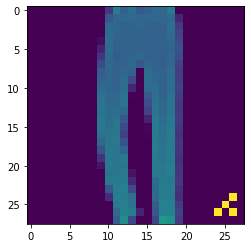

In [ ]:
for _ in range(n_experiments):
  for source_label in source_labels:
    for target_label in target_labels:
      if source_label == 0 and target_label == 7:
        continue
      if source_label == 1 and target_label == 9:
        continue
      if source_label == target_label:
        continue
      else:

        print('\n')
        print('{} -> {}'.format(source_label, target_label))

        dataset_train_users_dataloaders, test_dataset = get_dataset(MODE, n_clients, batch_size_train, batch_size_train, n_classes)
        test_dataset = DevicedataLoader(test_dataset, device)

        del dataset_train_users_dataloaders
        
        # Load the last averaged model
        model, optimizer, criterion = build_model(lr, momentum, n_classes)
        
        model.load_state_dict(model_w)
  
        poisoned_dataset = label_flipping(fake_dataset, source_label=source_label,
                                target_label=target_label, eps=eps, batch_size_train=batch_size_train)
        
        # Also create a fully backdoores test set
        test_dataset_poisoned = label_flipping(test_dataset, source_label=source_label,
                                target_label=target_label, eps=1, batch_size_train=batch_size_train, mode='Train')

        poisoned_model, optimizer, poisoned_criterion, loss, acc = train(
            n_fl_poisoned, model, optimizer, criterion, poisoned_dataset, True)

        print('\n Evaluation per class POISONED')
        acc_poison = validation_per_class(poisoned_model, test_dataset)
        acc_poison_poisoned = validation_per_class(poisoned_model, test_dataset_poisoned)

        print('Number of backdoored samples {} '.format(test_dataset_poisoned.dl.dataset.tensors[0].shape))


        loss, acc_val_poison = validation(poisoned_model, test_dataset, poisoned_criterion)
        loss_poisoned, acc_val_poison_poisoned = validation(poisoned_model, test_dataset_poisoned, poisoned_criterion)

        print('Backdoored acc {}'.format(acc_val_poison_poisoned))

        print('\n Evaluation per class')
        acc = validation_per_class(s_model, test_dataset)
        loss, acc_val = validation(
            s_model, test_dataset, s_crit)
        
        if source_label == 0:
          acc_poisoned_0_9.append(acc_val_poison[-1])
          list_acc_per_label_poison_0_9.append(acc_poison.numpy())

          acc_poisoned_0_9_poisoned.append(acc_val_poison_poisoned[-1])
          list_acc_per_label_poison_0_9_poisoned.append(acc_poison_poisoned.numpy())

          accur_0_9.append(acc_val[-1])
          list_acc_per_label_0_9.append(acc.numpy())
        else:
          acc_poisoned_1_7.append(acc_val_poison[-1])
          list_acc_per_label_poison_1_7.append(acc_poison.numpy())

          acc_poisoned_1_7_poisoned.append(acc_val_poison_poisoned[-1])
          list_acc_per_label_poison_1_7_poisoned.append(acc_poison_poisoned.numpy())

          accur_1_7.append(acc_val[-1])
          list_acc_per_label_1_7.append(acc.numpy())

##### Results

In [ ]:
print('\n')
print('###############################')
print('ATTACK FINISHED')
print('###############################')
print('Plotting results')

mean_per_class_0_9 = np.mean(list_acc_per_label_0_9, axis=0)
mean_per_class_1_7 = np.mean(list_acc_per_label_1_7, axis=0)
mean_per_class_poison_0_9 = np.mean(list_acc_per_label_poison_0_9, axis=0)
mean_per_class_poison_1_7 = np.mean(list_acc_per_label_poison_1_7, axis=0)
mean_per_class_poison_0_9_poisoned = np.mean(list_acc_per_label_poison_0_9_poisoned, axis=0)
mean_per_class_poison_1_7_poisoned = np.mean(list_acc_per_label_poison_1_7_poisoned, axis=0)

acc_mean_0_9 = np.mean(accur_0_9)
acc_mean_1_7 = np.mean(accur_1_7)
acc_poison_mean_0_9 = np.mean(acc_poisoned_0_9)
acc_poison_mean_1_7 = np.mean(acc_poisoned_1_7)
acc_poison_mean_0_9_poisoned = np.mean(acc_poisoned_0_9_poisoned)
acc_poison_mean_1_7_poisoned = np.mean(acc_poisoned_1_7_poisoned)

print('\n')
print('Mean accuracy 1->7: {}'.format(acc_mean_1_7))
print('Mean accuracy poisoned 1->7: {}'.format(acc_poison_mean_1_7))
print('Mean accuracy poisoned on poisoned testset 1->7: {}'.format(acc_poison_mean_1_7_poisoned))

print('Mean accuracy per class 1->7: {}'.format(mean_per_class_1_7))
print('Mean accuracy per class poisoned 1->7: {}'.format(mean_per_class_poison_1_7))
print('Mean accuracy per class poisoned on poisoned testset 1->7: {}'.format(mean_per_class_poison_1_7_poisoned))


print('\n')
print('Mean accuracy 0->9: {}'.format(acc_mean_0_9))
print('Mean accuracy poisoned 0->9: {}'.format(acc_poison_mean_0_9))
print('Mean accuracy poisoned on poisoned testset 0->9: {}'.format(acc_poison_mean_0_9_poisoned))

print('Mean accuracy per class 0->9: {}'.format(mean_per_class_0_9))
print('Mean accuracy per class poisoned 0->9: {}'.format(mean_per_class_poison_0_9))
print('Mean accuracy per class poisoned on poisoned testset 0->9: {}'.format(mean_per_class_poison_0_9_poisoned))



###############################
ATTACK FINISHED
###############################
Plotting results


Mean accuracy 1->7: 77.38
Mean accuracy poisoned 1->7: 72.248
Mean accuracy poisoned on poisoned testset 1->7: 72.181
Mean accuracy per class 1->7: [0.678      0.89900005 0.624      0.8190001  0.70699996 0.87099993
 0.454      0.8579999  0.91999996 0.908     ]
Mean accuracy per class poisoned 1->7: [0.73240006 0.0016     0.7506     0.8863999  0.785      0.94990003
 0.48820004 0.7808     0.8921999  0.95769995]
Mean accuracy per class poisoned on poisoned testset 1->7: [0.7313            nan 0.7458     0.8839     0.79019994 0.94869995
 0.4848     0.38944998 0.89180005 0.95930004]


Mean accuracy 0->9: 77.38
Mean accuracy poisoned 0->9: 75.15899999999999
Mean accuracy poisoned on poisoned testset 0->9: 75.178
Mean accuracy per class 0->9: [0.678      0.89900005 0.624      0.8190001  0.70699996 0.87099993
 0.454      0.8579999  0.91999996 0.908     ]
Mean accuracy per class poisoned 0->9: [